In [64]:
import os
import pandas as pd
import numpy as np
import lightgbm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_log_error, confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import normalize, OneHotEncoder


Read the training and test data

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df  = pd.read_csv("data/test.csv")

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#extract cabin letters and numbers
def feature_extraction(df):
    def get_surname(x):
        return x['Name'].apply(lambda x: x.split(',')[0])
    def get_prefix(x):
        return x['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    def firstname_split(x):
        res = x.split(',')[1].split('.')[1].strip().split(' ')[0]
        return res.replace('(', '').replace(')', '')
    def get_firstname(x):
        return x['Name'].apply(firstname_split)
    def extract_cabin_letter(x):
        if x is np.nan: 
            return ''
        else: 
            return x[0].upper()
    def extract_cabin_num(x):
        if x is np.nan: 
            return ''
        else: 
            return x[1:]
    def get_ticket_pre(x):
        #if it is int, then this is actually the ticket number so ignore for next function
        res = x.split(' ')[0]
        try:
            res = int(res)
            return ''
        except:
            return res
    def get_ticket_num(x):
        res = x.split(' ')[-1]
        return res
    df['Cabin_L']   = df['Cabin'].apply(extract_cabin_letter)
    df['Cabin_N']   = df['Cabin'].apply(extract_cabin_num)
    df['Surname']   = get_surname(df)
    df['Prefix']    = get_prefix(df)
    df['Firstname'] = get_firstname(df)
    df['Ticket_C']  = df['Ticket'].apply(get_ticket_pre)
    df['Ticket_N']  = df['Ticket'].apply(get_ticket_num)
    df['Ticket_Level'] = df['Ticket_N'].apply(lambda x: x[0])

    return df

In [5]:
train_df = feature_extraction(train_df)
test_df = feature_extraction(test_df)

In [6]:
train_df[train_df.isna().any(axis=1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_L,Cabin_N,Surname,Prefix,Firstname,Ticket_C,Ticket_N,Ticket_Level
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,,,Braund,Mr,Owen,A/5,21171,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,,,Heikkinen,Miss,Laina,STON/O2.,3101282,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,,,Allen,Mr,William,,373450,3
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,,,Moran,Mr,James,,330877,3
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,,,Palsson,Master,Gosta,,349909,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S,,,Sutehall,Mr,Henry,SOTON/OQ,392076,3
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q,,,Rice,Mrs,William,,382652,3
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,,,Montvila,Rev,Juozas,,211536,2
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,,,Johnston,Miss,Catherine,W./C.,6607,6


In [7]:
Counter(train_df['Prefix'])

Counter({'Mr': 517,
         'Mrs': 125,
         'Miss': 182,
         'Master': 40,
         'Don': 1,
         'Rev': 6,
         'Dr': 7,
         'Mme': 1,
         'Ms': 1,
         'Major': 2,
         'Lady': 1,
         'Sir': 1,
         'Mlle': 2,
         'Col': 2,
         'Capt': 1,
         'the Countess': 1,
         'Jonkheer': 1})

<AxesSubplot:xlabel='Prefix'>

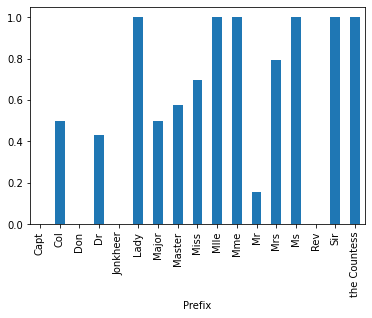

In [8]:
train_df.groupby('Prefix').mean()['Survived'].plot.bar()

In [55]:
def pre_process(df):
    columns  = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'Sex', 'Embarked', 'Surname', 'Prefix', 'Firstname', 
                'Cabin_L', 'Cabin_N',
                'Ticket_C', 'Ticket_N', 'Ticket_Level']
    scale_cols = ['Age', 'Fare']
    cat_cols = ['Pclass', 'Sex', 'Surname', 'Prefix', 'Embarked', 'Firstname', 'Cabin_L', 'Cabin_N', 'Ticket_C', 'Ticket_N', 'Ticket_Level']
    X = df[columns].copy()
    y = None
    if 'Survived' in df.columns:
        y = df.Survived
    for c in cat_cols:#X.columns:
        #col_type = X[c].dtype
        #if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')
    #X['Age'].fillna(X['Age'].median(), inplace = True)
    #X['Fare'].fillna(X['Fare'].median(), inplace = True)
    #print(X.isna().any())
    scaled_X = X.copy()
    def my_standardize(x):
        return (x - x.min())/x.std()
    def my_normalize(x):
        return (x - x.min())/(x.max()-x.min())
    #arr = normalize(np.array(X[scale_cols[0]]).reshape(-1,1))
    #print(np.isnan(arr).any())
    for c in scale_cols:
        scaled_X[c] = my_standardize(scaled_X[c])
    #    scaled_X[c] = normalize(np.array(X[c]).reshape(-1,1))
    return scaled_X, y

In [56]:
X_train, y_train = pre_process(train_df)
X_test           = pre_process(test_df)

In [57]:
X_train

,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked,Surname,Prefix,Firstname,Cabin_L,Cabin_N,Ticket_C,Ticket_N,Ticket_Level
0,1.485561,1,0,0.145895,3,male,S,Braund,Mr,Owen,,,A/5,21171,2
1,2.586997,1,0,1.434461,1,female,C,Cumings,Mrs,John,C,85,PC,17599,1
2,1.760920,0,0,0.159478,3,female,S,Heikkinen,Miss,Laina,,,STON/O2.,3101282,3
3,2.380477,1,0,1.068552,1,female,S,Futrelle,Mrs,Jacques,C,123,,113803,1
4,2.380477,0,0,0.161993,3,male,S,Allen,Mr,William,,,,373450,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1.829760,0,0,0.261604,2,male,S,Montvila,Rev,Juozas,,,,211536,2
887,1.279042,0,0,0.603702,1,female,S,Graham,Miss,Margaret,B,42,,112053,1
888,NaN,1,2,0.471893,3,female,S,Johnston,Miss,Catherine,,,W./C.,6607,6
889,1.760920,0,0,0.603702,1,male,C,Behr,Mr,Karl,C,148,,111369,1


In [58]:
Counter(y_train)

Counter({0: 549, 1: 342})

In [59]:
lgb = lightgbm.LGBMClassifier()

In [60]:
lgb.fit(X_train, y_train)

LGBMClassifier()

In [61]:
predicted_y = lgb.predict(X_train)


In [62]:
print(classification_report(y_train, predicted_y))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       549
           1       0.99      0.95      0.97       342

    accuracy                           0.98       891
   macro avg       0.98      0.97      0.98       891
weighted avg       0.98      0.98      0.98       891



In [63]:
print(confusion_matrix(y_train, predicted_y))

[[546   3]
 [ 17 325]]


In [53]:
print(confusion_matrix(y_train, predicted_y))

[[546   3]
 [ 17 325]]


In [18]:
probs = lgb.predict_proba(X_train)

In [19]:
fpr, tpr, thresholds = roc_curve(y_train, probs[:,1])

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.938


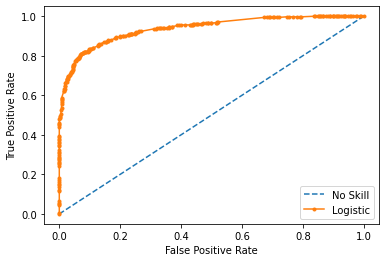

In [20]:
ns_probs = [0 for _ in range(len(y_train))]
lr_probs = probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_train, ns_probs)
lr_auc = roc_auc_score(y_train, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_train, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_train, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [21]:
lgb.score(X_train, y_train)

0.8799102132435466

In [22]:
lgb.score

<bound method ClassifierMixin.score of LGBMClassifier()>

In [23]:
lgb.feature_importances_

array([  0, 391, 312,   0, 403, 323, 443,   0,  59,  31,  50,  10,  38,
         0,  73])

In [66]:
idx = np.where(y_train != predicted_y)
idx

(array([ 36,  55, 107, 264, 267, 271, 288, 301, 391, 414, 444, 510, 569,
        570, 574, 579, 587, 630, 826, 828], dtype=int64),)

In [68]:
probs[idx]

array([[0.84033177, 0.15966823],
       [0.6762025 , 0.3237975 ],
       [0.91678629, 0.08321371],
       [0.21992744, 0.78007256],
       [0.91337482, 0.08662518],
       [0.89611378, 0.10388622],
       [0.94215845, 0.05784155],
       [0.82494853, 0.17505147],
       [0.91678629, 0.08321371],
       [0.72037315, 0.27962685],
       [0.91478475, 0.08521525],
       [0.93019966, 0.06980034],
       [0.91678629, 0.08321371],
       [0.77153644, 0.22846356],
       [0.9310118 , 0.0689882 ],
       [0.71990126, 0.28009874],
       [0.29638664, 0.70361336],
       [0.82875458, 0.17124542],
       [0.45777813, 0.54222187],
       [0.89841514, 0.10158486]])

In [67]:
train_df.iloc[idx]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_L,Cabin_N,Surname,Prefix,Firstname,Ticket_C,Ticket_N,Ticket_Level
36,37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C,,,Mamee,Mr,Hanna,,2677,2
55,56,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S,C,52,Woolner,Mr,Hugh,,19947,1
107,108,1,3,"Moss, Mr. Albert Johan",male,NaN,0,0,312991,7.7750,NaN,S,,,Moss,Mr,Albert,,312991,3
264,265,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q,,,Henry,Miss,Delia,,382649,3
267,268,1,3,"Persson, Mr. Ernst Ulrik",male,25.0,1,0,347083,7.7750,NaN,S,,,Persson,Mr,Ernst,,347083,3
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,NaN,S,,,Tornquist,Mr,William,LINE,LINE,L
288,289,1,2,"Hosono, Mr. Masabumi",male,42.0,0,0,237798,13.0000,NaN,S,,,Hosono,Mr,Masabumi,,237798,2
301,302,1,3,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.2500,NaN,Q,,,McCoy,Mr,Bernard,,367226,3
391,392,1,3,"Jansson, Mr. Carl Olof",male,21.0,0,0,350034,7.7958,NaN,S,,,Jansson,Mr,Carl,,350034,3
414,415,1,3,"Sundman, Mr. Johan Julian",male,44.0,0,0,STON/O 2. 3101269,7.9250,NaN,S,,,Sundman,Mr,Johan,STON/O,3101269,3
